## Multiclass MLP

Example of a multiclass MLP ( Multi layer perceptron ) in Keras.

It uses the UCI `iris` dataset as an example.

# 1 - Packages

Run the cell below to import the packages we need

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from pandas import read_csv
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6]

## 2 - Loading the dataset

The `iris` dataset is a well studied dataset and previous studies managed to produce an accuracy of 95% to 97%. This is the baseline target we are aiming for here.

The `iris` dataset comprises of 5 columns where the first four define the attributes and the last define the category of the sample. The attributes are all numeric and within acceptable same centimeters scale so we will not perform any normalization on the dataset. We need to one-hot encode the category labels.



In [8]:
seed = 7
np.random.seed(seed)

absdir = os.path.dirname(os.path.realpath('__file__'))
datapath = "../data/iris.csv"
dataframe = read_csv(os.path.join(absdir, datapath), header=None)
dataset = dataframe.values
X = dataset[:, 0:4].astype(float)
y = dataset[:, 4]

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

# encode class values as integers then one-hot encode
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)
print(dummy_y[0])

(150, 4)
(150,)
[5.1 3.5 1.4 0.2]
Iris-setosa
[1. 0. 0.]


## 3 - Network Structure

We will create a basic network of the following structure:

`
Inputs (4) -> Hidden Layer (8) -> Output Layer (3)
`

We will use the `ReLU` activation function in the hidden layers and the `softmax` activation function in the output layer since it is a multiclass classification problem.

We optimize against the crossentropy log loss using the `categorical_crossentropy` and the `Adam` optimizer to speed up learning.

We train the model using mini-batch gradient descent with a batch size of 5 for 200 epochs.

In [47]:
def base_model():
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

model = base_model()
history = model.fit(X, dummy_y, epochs=200, batch_size=5, verbose=0)

scores = model.evaluate(X, dummy_y, verbose=0)
print("{}: {:.2f}%".format(model.metrics_names[0].capitalize(), scores[0]*100))
print("{}: {:.2f}%".format(model.metrics_names[1].capitalize(), scores[1]*100))

Loss: 11.95%
Acc: 98.00%


## 4 - Plotting model performance

We can obtain the training loss and accuracy via the history object above and using it to plot the training performance. We can see from the plot that the training loss does decrease with each epoch. 

The training accuracy increases per epoch and plateaus from the 125th epoch onwards.

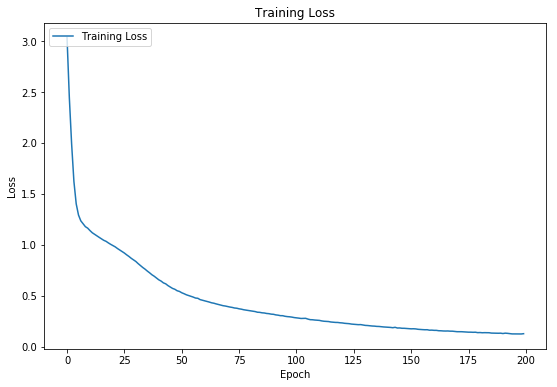

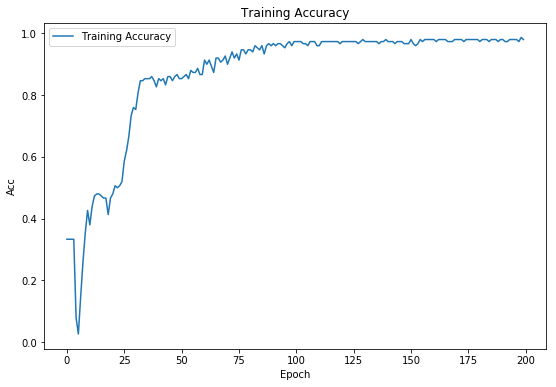

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['acc'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## 5 - Manual KFold cross validation

Using the history object above, we are only able to obtain the loss and accuracy metrics. 

For the iris dataset, since we only have 150 samples, setting aside a proportion as a test set will impact the training performance. i.e. try adding `validation_split=0.25` to `model.fit`

We can integrate keras models with scikit learn to utilize `KFold` cross validation which will provide a more detailed analysis of the model's performance.

Since kfold returns a pair of train,test indices, we can use it to manually iterate through the dataset and run the training and validation processes in order to store the metrics into external lists which we can use to plot later.

In [50]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
t_loss = []
cv_loss = []
for train, test in kfold.split(X, dummy_y):
    hist = model.fit(X[train], dummy_y[train], epochs=200, batch_size=5, verbose=0)
    # mean loss for each fold?
    t_loss.append(np.mean(hist.history['loss']) * 100)
    # t_loss.append(hist.history['loss'])
    scores = model.evaluate(X[test], dummy_y[test], verbose=0)
    cv_loss.append(scores[0] * 100)
print(t_loss)
print(cv_loss)

[5.167056308920328, 4.141728814802846, 4.97789872270823, 5.19626460345712, 5.1367907130284465, 5.1007953866347915, 5.093448503174578, 3.0387943542556783, 3.8962322768799496, 4.413230904074145]
[1.851857267320156, 10.497460514307022, 2.8649061918258667, 0.05129839410074055, 0.22673059720546007, 0.15917137498036027, 0.03828293993137777, 18.893760442733765, 13.001640141010284, 6.52494877576828]


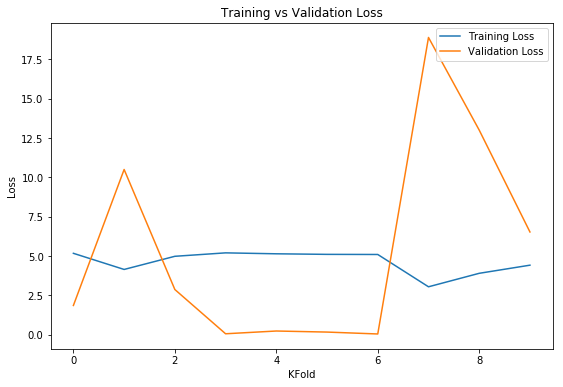

In [51]:
plt.plot(t_loss, label='Training Loss')
plt.plot(cv_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('KFold')
plt.legend(loc="upper right")
plt.show()

## 6 - Automatic KFold validation

We can create an estimator object using the built-in `KerasClassifier` and pass it to the scikit learn `cross_val_score` function to compute the cross validation scores across all the folds automatically. It will return a list of accuracy scores, from which we can compute the mean accuracy and standard deviation. The standard deviation of the accuracy scores will provide an indication of the `stability` of the network.

From running the cell below, it should report an accuracy of approx `96.67%` which is within the target we are aiming for with a standard deviation of approx. `4.472`

In [52]:
estimator = KerasClassifier(build_fn=base_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print(results)
print(results.mean() * 100)
print(results.std() * 100)

[1.         0.93333334 1.         1.         1.         1.
 1.         0.93333334 0.93333334 0.86666667]
96.66666686534882
4.472135688439504
